In [2]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import scipy as sp
import numpy as np
import pickle

import seaborn as sns
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import itertools

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

<h3>Load Data</h3>
We will use previously transformed data from the last notebook 'LeadScoring_DataPrepping.ipynb'

<p>Data files used:

<li><b>sf_leads_leadscoring_20180307</b> - Data exported from SF. Uses order_id__c, tenant as primiary keys
<li><b>ga_user_paths_20180306</b>  - Data exported from GA, records landingpagepath history from GA and marketing sources of each session
<li><b>trial_conversions_20180308</b> - Data exporter from stripe and BI warehouse, indicates whether or not the trial eventually converted

In [3]:
pca_X = np.load('pca_features_X.npy')
X = np.load('raw_features_X.npy')
Y = np.load('targetdata.npy')

In [10]:
pca_weights = pd.read_csv('PCA_weights.csv', index_col=False)

In [12]:
pca_weights.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,affiliate_touch,-0.001050,-0.148780,-0.115610,-0.125987,-0.127985,0.176867,-0.071505,0.408875,0.061175,0.072378,0.038637,-0.038081,0.155960,-0.068785,-0.039437,0.002518,-0.027693,-0.002160,-0.049076,0.072252,0.024943,0.003237,0.062220,-0.040354,0.090836,-0.004399,0.007927,-0.187936,-0.479473,0.151325,0.032946,0.171282,0.003193,-0.008952,0.022713,0.074102,-0.057355,0.032599,-0.051067,0.076287,-0.076645,-0.073184,0.128086,0.068138,0.058669,0.214558,-0.031421,0.027918,0.015831,-0.020018,-0.017018,0.016169,-0.140132,0.033705,0.075948,0.017409,0.037250,-0.028946,-0.057422,-0.018747,0.029998,0.048407,-0.011580,-0.035469,-0.083591,0.090997,0.344688,-0.061582,-0.002763,-0.037991,-0.001150,-0.063626,0.010104,0.028824,-0.011681,-0.004509,-0.069428,0.121189,-0.033702,-0.097885,0.013228,0.029414,0.012737,0.016139,0.007328,-0.011510,0.047226,-0.054036,-0.053103,0.016072,0.053288,-0.019032,0.043757,0.020525,0.034267,-0.017911,-0.000148,-0.016042,0.016976,0.045488,-4.409393e-04,0.014284,-0.002283,-0.009456,0.005374,0.004738,-0.019440,-0.008194,0.020694,0.008189,0.000591,-0.034873,0.006528,-0.011830,0.002539,-0.002577,0.000568,-0.003972,-0.005910,-0.011699,0.004811,0.001617,0.008001,0.006497,-0.002671,-0.002551,0.002150,-0.001507,0.004132,0.003441,0.003779,0.004518,0.009856,0.004119,0.001213,0.001647,0.000314,-0.003267,-0.004440,0.001070,-0.001262,0.001481,0.000321,0.004930,-0.001087,0.006743,0.002691,-0.003679,-0.001173,0.002599,0.000907,0.002158,-0.001510,-0.005145,0.005710,-0.003596,-0.005004,0.010266,-0.002704,0.001708,-0.002270,0.000578,0.000201,-0.002374,-0.000450,-0.001731,0.003304,-0.001369,-0.001185,0.004847,-0.006340,-0.001877,0.001097,-0.000175,0.001976,-0.000657,0.002668,0.005784,-0.000541,0.005246,-0.000632,-0.001314,0.009700,-0.005533,-0.008088,-0.007245,0.010015,0.003923,0.013500,-0.009655,0.002223,-0.003190,0.006396,-0.005524,0.001721,0.006436,0.000915,0.000775,0.004966,0.002684
1,Have_products,0.000049,-0.000996,-0.006292,0.003080,0.005961,-0.005566,-0.003709,0.002624,-0.005846,-0.000379,-0.000515,0.003166,0.003657,0.015599,0.012978,0.002233,0.014675,-0.007027,-0.054125,-0.003041,-0.104681,-0.111607,-0.018031,-0.030898,-0.009713,-0.015043,0.040490,0.010750,-0.005253,0.002621,0.002420,-0.013000,-0.002128,-0.009853,0.000800,0.003982,0.000902,-0.005186,-0.010544,-0.023043,-0.003446,-0.023791,0.009997,-0.001381,0.009679,0.003086,-0.008065,-0.005235,0.022980,0.003206,-0.015963,0.021332,-0.026431,0.016726,-0.011500,-0.004262,0.011854,-0.047819,0.003370,-0.006062,-0.044257,-0.038512,-0.007042,-0.002225,-0.017698,-0.024048,-0.013083,0.007874,-0.075181,0.024535,0.000381,0.035223,-0.112122,-0.036533,0.035853,-0.007066,0.714704,0.562254,0.098098,0.104684,-0.145665,0.106552,0.180254,-0.054441,0.030587,0.020552,-0.023894,-0.028832,0.029474,0.051278,-0.010950,0.016195,-0.014087,0.006516,0.045697,-0.011078,0.004811,0.005862,-0.000509,0.028320,1.279336e-02,-0.008519,0.044047,0.018183,-0.000142,-0.009260,-0.015236,0.011686,-0.003048,-0.015444,0.013110,-0.004396,0.000386,0.002085,-0.020579,0.009605,0.000439,-0.006450,-0.001231,-0.009500,-0.003893,-0.011431,0.004765,0.027740,0.007853,-0.006554,-0.008717,-0.008758,0.002460,-0.000047,0.001398,-0.008023,-0.002515,0.000538,-0.006915,-0.001874,0.003946,0.005781,-0.002571,0.004583,0.007334,-0.001955,-0.018597,0.012

In [13]:
X_train, X_test, y_train, y_test = train_test_split(pca_X, Y, test_size = 0.4, random_state = 4)

In [14]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
cv_score = cross_val_score(lr, X_train, y_train, cv=10)

In [16]:
cv_score.mean()

0.92612173785014051

In [17]:
y_train[np.where(y_train[:] == 1)].sum()

1351

In [18]:
y_train[np.where(y_train[:] == 1)].sum()*1.0/len(y_train)

0.082418252806246955

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[14923   118]
 [ 1059   292]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.78  0.22]]


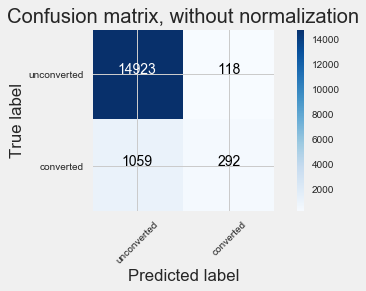

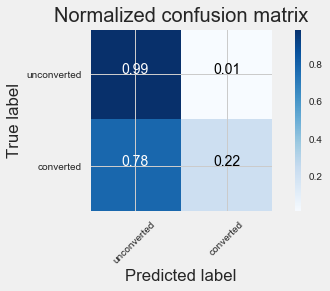

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, lr.predict(X_train))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
f1 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['unconverted', 'converted'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
f2 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['unconverted', 'converted'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()
f1.savefig('logreg_confusion_matrix_total.png')
f1.savefig('logreg_confusion_matrix_norm.png')